In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from models import CNNClassifier
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [2]:
Q = 6
nconf = 81
ndata = 200
L = 64
T_cr_1 = 0.701 # critical temp for 2d clock
T_cr_2 = 0.898 # critical temp for 2d clock
t_start = 0.4

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Clock", q=Q)
# print(prm_list)
print(f"データ数:{nconf*ndata}")

データ数:16200


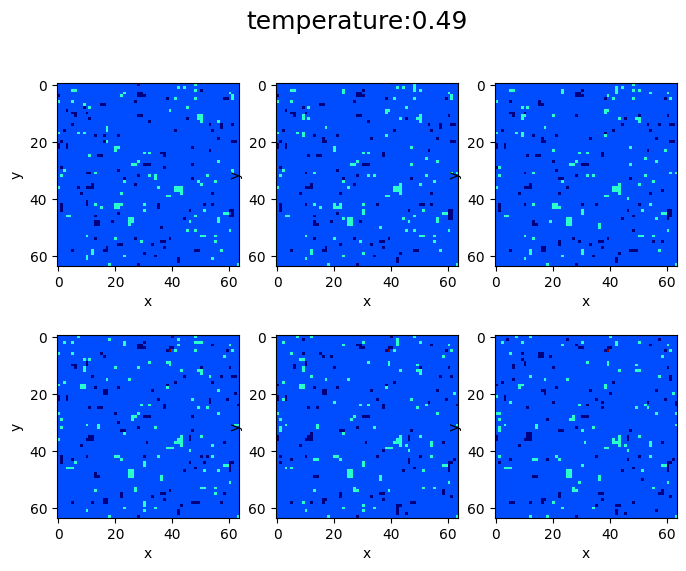

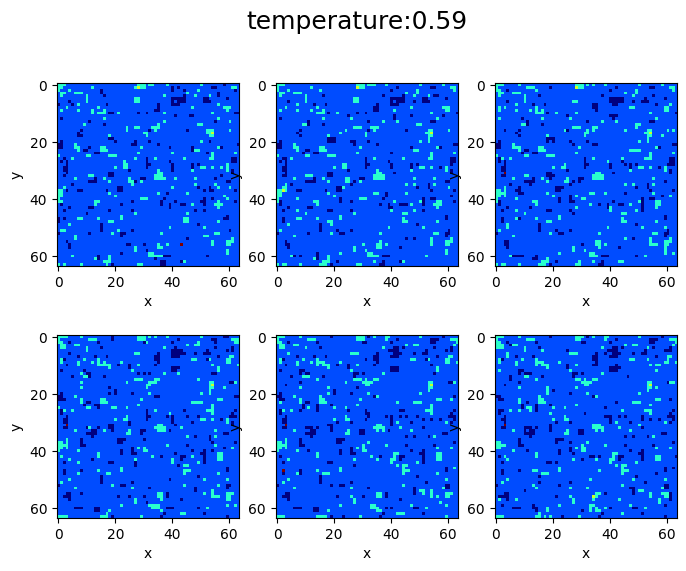

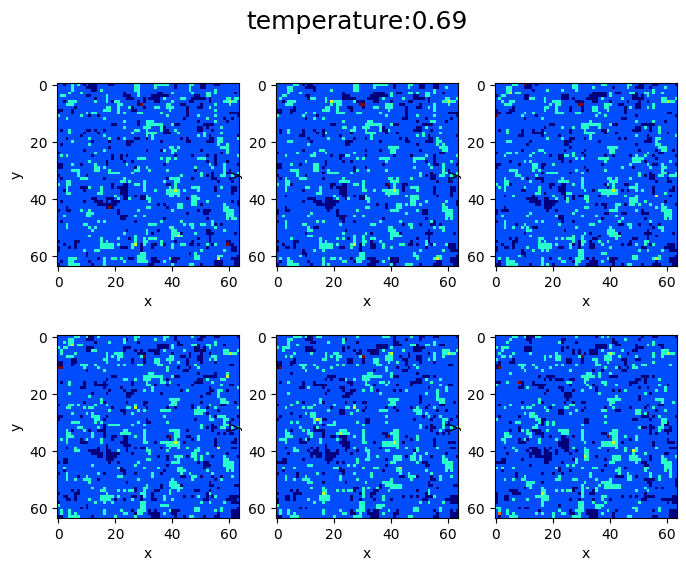

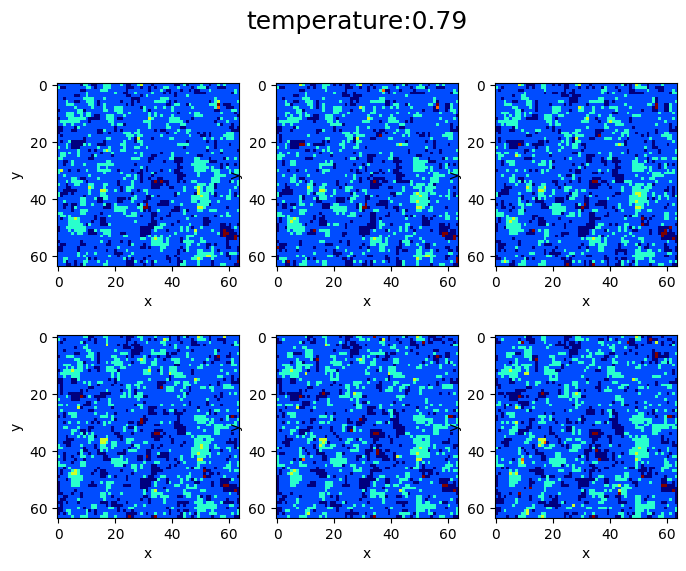

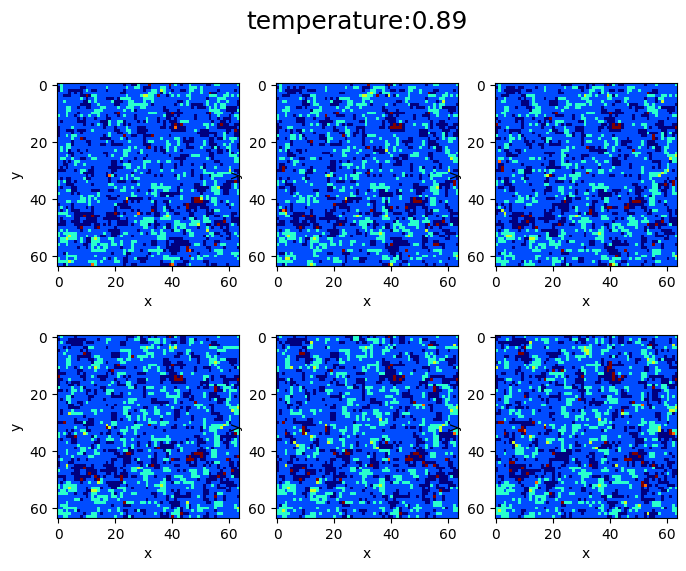

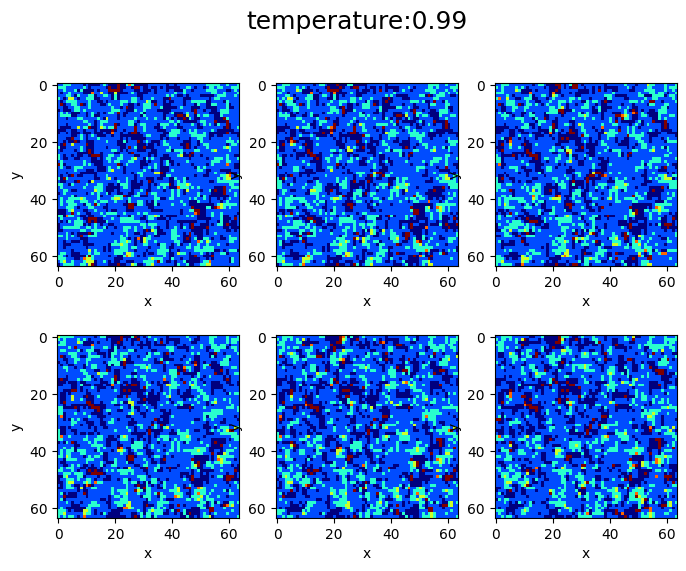

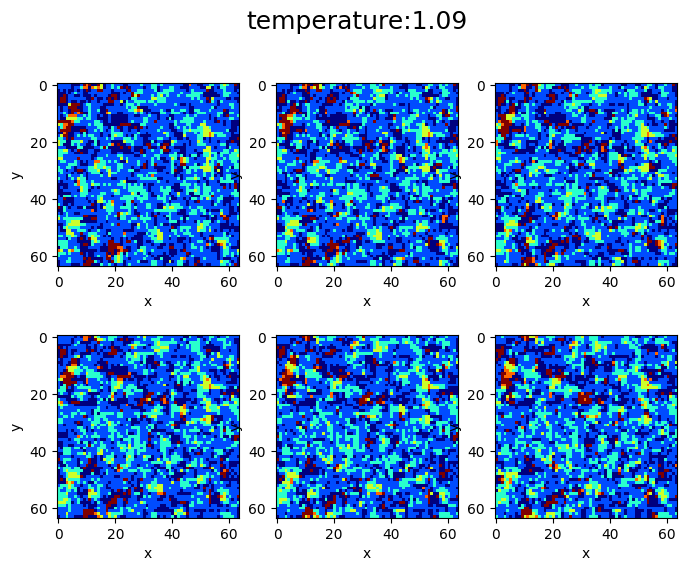

In [13]:
# 可視化
row = 2  # 行数
col = 3  # 列数

for num in range(9, 79, 10):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
    fig.suptitle(f"temperature:{prm_list[num][0]}", fontsize=18, color='black')
    for iconf in range(6):
        _r = iconf//col
        _c = iconf % col
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)

        ax[_r,_c].set_xlabel('x')
        ax[_r,_c].set_ylabel('y')
        ax[_r,_c].imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')

In [4]:
dataset, _ = create_train_data_CV(prm_list=prm_list, ndata=ndata, T_cr_1=T_cr_1, T_cr_2=T_cr_2, exclude_T=(0.65, 0.76, 0.84, 0.95), total_label=3)
print("dataset.shape = ", len(dataset))

dataset.shape =  11400


mps is available.
FOLD 1
--------------------------------
Epoch: 10, Validation loss: 4.3261521023739254e-05, Accuracy: 99.91228070175438%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       984
           1     1.0000    0.9933    0.9966       298
           2     0.9980    1.0000    0.9990       998

    accuracy                         0.9991      2280
   macro avg     0.9993    0.9978    0.9985      2280
weighted avg     0.9991    0.9991    0.9991      2280



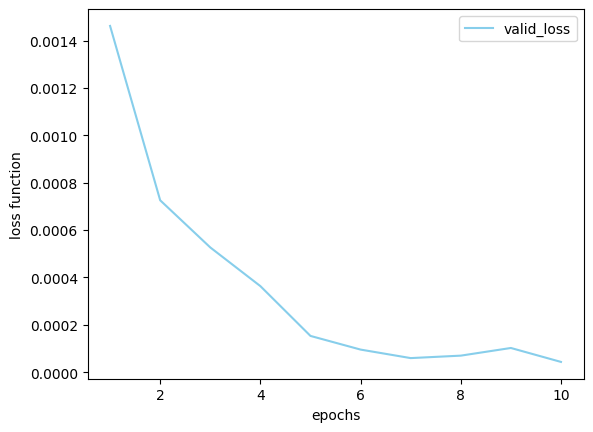

FOLD 2
--------------------------------
Epoch: 10, Validation loss: 9.99843208965582e-06, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1019
           1     1.0000    1.0000    1.0000       284
           2     1.0000    1.0000    1.0000       977

    accuracy                         1.0000      2280
   macro avg     1.0000    1.0000    1.0000      2280
weighted avg     1.0000    1.0000    1.0000      2280



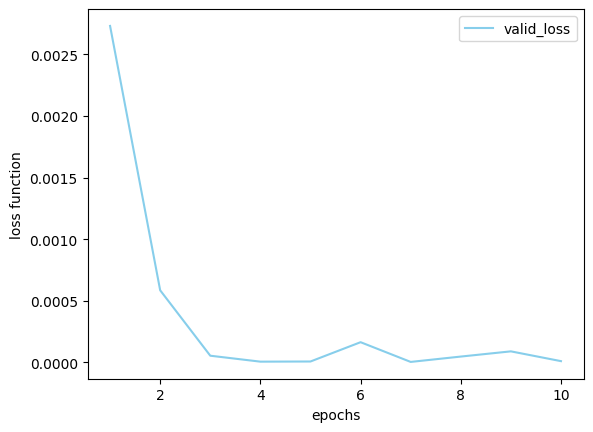

FOLD 3
--------------------------------
Epoch: 10, Validation loss: 5.30507536865842e-05, Accuracy: 99.86842105263158%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       973
           1     1.0000    0.9897    0.9948       292
           2     0.9971    1.0000    0.9985      1015

    accuracy                         0.9987      2280
   macro avg     0.9990    0.9966    0.9978      2280
weighted avg     0.9987    0.9987    0.9987      2280



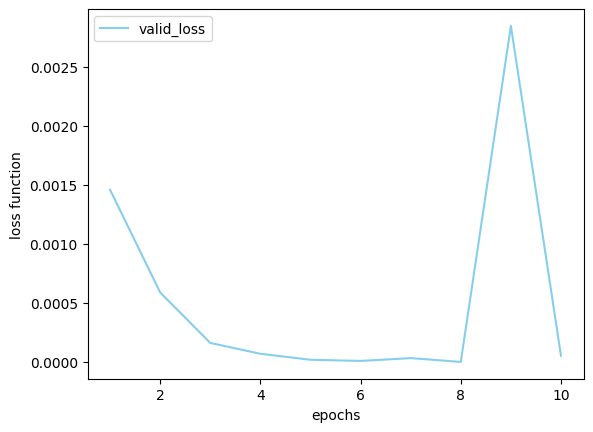

FOLD 4
--------------------------------
Epoch: 10, Validation loss: 8.939100279061868e-06, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1007
           1     1.0000    1.0000    1.0000       267
           2     1.0000    1.0000    1.0000      1006

    accuracy                         1.0000      2280
   macro avg     1.0000    1.0000    1.0000      2280
weighted avg     1.0000    1.0000    1.0000      2280



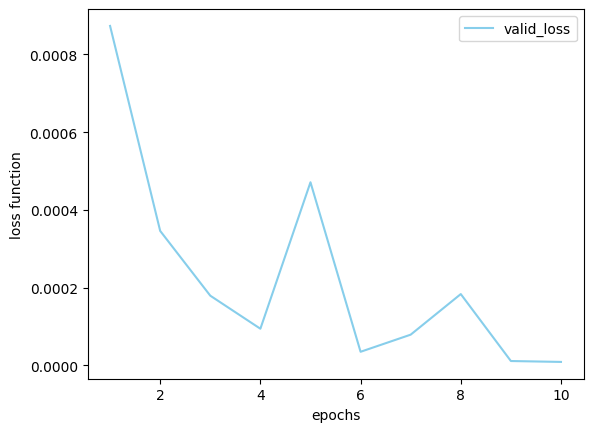

FOLD 5
--------------------------------
Epoch: 10, Validation loss: 4.786403559891446e-08, Accuracy: 100.0%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1017
           1     1.0000    1.0000    1.0000       259
           2     1.0000    1.0000    1.0000      1004

    accuracy                         1.0000      2280
   macro avg     1.0000    1.0000    1.0000      2280
weighted avg     1.0000    1.0000    1.0000      2280



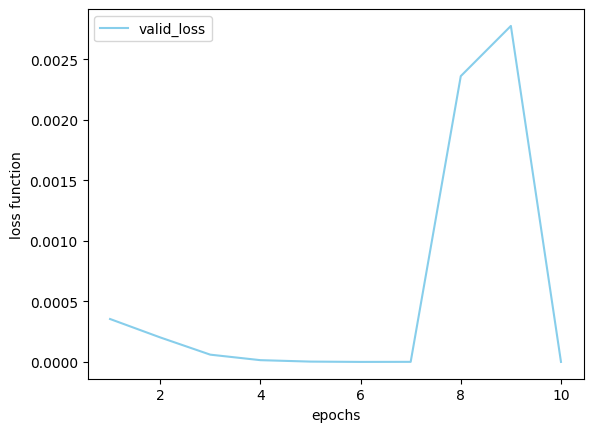

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
Done.


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
target_size = 3
grad_clip = 0.1
norm_type = 2
epochs = 10
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)

    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)
    # weights = torch.tensor([1.0, 5.0, 1.0]).to(device)

    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loss_list, vaild_loss_list, accuracy_list = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            correct = 0
            answer, prediction = [], []
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                prediction += list(pred.cpu().numpy())
                answer += list(target.cpu().numpy())

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)

        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch == epochs-1:
            print(
                f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
            print("Classification Report:\n", classification_report(
            answer, prediction, digits=4))
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list,
             label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")
# torch.save(model, "2d_Clock_q=6_model_classifier.pth")

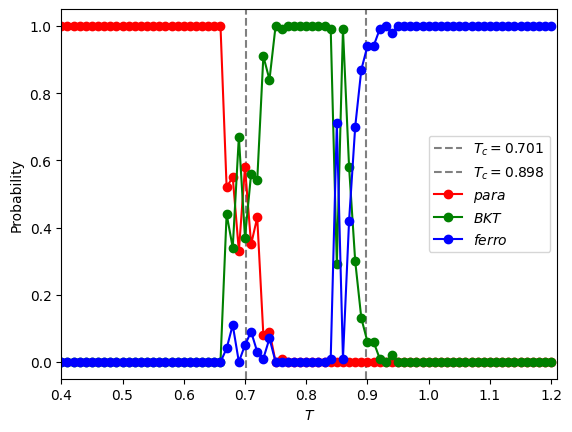

In [6]:
_, test_dataset = create_train_data_hold_out(
        prm_list=prm_list, 
        ndata=ndata, 
        T_cr_1=T_cr_1, 
        T_cr_2=T_cr_2, 
        exclude_T=(0.65, 0.76, 0.84, 0.95), 
        total_label=3
    )
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


def pred_count(sum_pred_0, sum_pred_1, sum_pred_2, prediction):
    if prediction == 0:
        sum_pred_0 += 1
    elif prediction == 1:
        sum_pred_1 += 1
    else:
        sum_pred_2 += 1
    return sum_pred_0, sum_pred_1, sum_pred_2


xs, y1s, y2s, y3s, temps = [], [], [], [], []
prediction = []
sum_pred_0, sum_pred_1, sum_pred_2 = 0, 0, 0
count = 0

model.eval()
for data, temp, target in test_loader:
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=False)
    prediction += list(pred.cpu().numpy())
    temps += list(temp.cpu().numpy())
# print(len(prediction), len(temps))

for i in range(len(test_dataset)):
    if i == 0:
        sum_pred_0, sum_pred_1, sum_pred_2 = pred_count(
            sum_pred_0, sum_pred_1, sum_pred_2, prediction[i])
        count += 1
        xs.append(temps[i])
    else:
        if temps[i] != temps[i-1]:
            # 格納
            y1s.append(sum_pred_0/count)
            y2s.append(sum_pred_1/count)
            y3s.append(sum_pred_2/count)

            sum_pred_0, sum_pred_1, sum_pred_2 = 0, 0, 0
            count = 0
            sum_pred_0, sum_pred_1, sum_pred_2 = pred_count(
                sum_pred_0, sum_pred_1, sum_pred_2, prediction[i])
            count += 1
            xs.append(temps[i])
        elif i == len(test_dataset)-1:
            # 格納
            y1s.append(sum_pred_0/count)
            y2s.append(sum_pred_1/count)
            y3s.append(sum_pred_2/count)
        else:
            sum_pred_0, sum_pred_1, sum_pred_2 = pred_count(
                sum_pred_0, sum_pred_1, sum_pred_2, prediction[i])
            count += 1
# print(len(xs), len(y1s), len(y2s), len(y3s))

plt.axvline(x=T_cr_1, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr_1))
plt.axvline(x=T_cr_2, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr_2))
plt.xlim(t_start, t_end)
plt.plot(xs, y1s, label=r"$para$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$BKT$", marker="o", color="green")
plt.plot(xs, y3s, label=r"$ferro$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()